# Deep Convolutional Generative Adversarial Network

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import PIL
from IPython import display

In [ ]:
path = "/content/drive/MyDrive/DL-CA3-q2/dataset"
dataset = keras.preprocessing.image_dataset_from_directory(
    directory=path, label_mode=None, image_size=(64, 64), batch_size=128,
    shuffle=True, seed=None, validation_split=None,
).map(lambda x: x/127.5 - 1)
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.cache().prefetch(buffer_size = AUTOTUNE)

Found 2872 files belonging to 1 classes.


### Displaying a sample image from dataset

sample image from dataset:


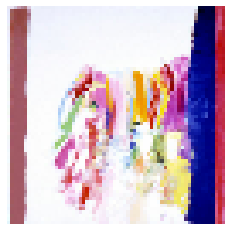

In [ ]:
print('sample image from dataset:')
for x in dataset:
    plt.axis("off")
    plt.imshow(((x.numpy()+1) * 127.5).astype("int32")[0])
    break

### Weights Initializer

In [ ]:
my_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)

### Generator Model

In [ ]:
latent_dim = 100
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(4 * 4 * 1024, kernel_initializer = my_init),
        layers.Reshape((4, 4, 1024)),
     
        layers.Conv2DTranspose(512, kernel_size=5, strides=2, padding="same", kernel_initializer = my_init),
        layers.BatchNormalization(),
        layers.ReLU(),
     
        layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding="same", kernel_initializer = my_init),
        layers.BatchNormalization(),
        layers.ReLU(),
     
        layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", kernel_initializer = my_init),
        layers.BatchNormalization(),
        layers.ReLU(),
     
        layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        13107712  
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      32

### Discriminator Model

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
     
        layers.Conv2D(128, kernel_size=5, strides=2, padding="same", kernel_initializer = my_init),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.LeakyReLU(alpha=0.2),
        layers.GaussianNoise(0.1), # Weakening discriminator
     
        layers.Conv2D(256, kernel_size=5, strides=2, padding="same", kernel_initializer = my_init),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.LeakyReLU(alpha=0.2),
        layers.GaussianNoise(0.1), # Weakening discriminator

        layers.Conv2D(512, kernel_size=5, strides=2, padding="same", kernel_initializer = my_init),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.25),
        layers.GaussianNoise(0.1), # Weakening discriminator

        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
print(discriminator.summary())

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       9728      
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 32, 32, 128)      0         
 se)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)     

### Optimizer and loss function

In [ ]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
loss_fn = keras.losses.BinaryCrossentropy()

### Generator Loss

In [ ]:
def generator_loss(output_):
    return loss_fn(tf.ones_like(output_), output_)

### Discriminator Loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_fn(tf.ones_like(real_output), real_output)
    fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Saving checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [ ]:
EPOCHS = 400
BATCH_SIZE = 128
noise_dim = 100
num_examples_to_generate = 9
seed = tf.random.normal([num_examples_to_generate, noise_dim])

### Train Function

In [ ]:
@tf.function
def training_help(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_imgs = generator(noise, training=True)

      real_d = discriminator(images, training=True)
      fake_d = discriminator(generated_imgs, training=True)

      gen_loss = generator_loss(fake_d)
      disc_loss = discriminator_loss(real_d, fake_d)

    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start_ = time.time()
    for image_batch in dataset:
      training_help(image_batch)

    display.clear_output(wait = True)
    generate_display_and_save_images(generator, epoch + 1, seed)
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    end_ = time.time()
    print ('Time for epoch {} is {} s'.format(epoch + 1, end_ - start_))

  # Final epoch
  display.clear_output(wait=True)
  generate_display_and_save_images(generator, epochs, seed)

In [ ]:
def generate_display_and_save_images(gen_, epoch, gen_input):
  predictions = gen_(gen_input, training = False)
  fig = plt.figure(figsize=(3, 3))
  for i in range(num_examples_to_generate):
      plt.subplot(3, 3, i+1)
      plt.imshow(predictions[i, :, :, :]*255)
      plt.axis('off')
  plt.savefig('./gen_images/image_epoch_{:03d}.png'.format(epoch))
  plt.show()

### Training Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


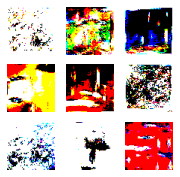

In [ ]:
train(dataset, EPOCHS)

### Display result of the Generator in a specific epoch

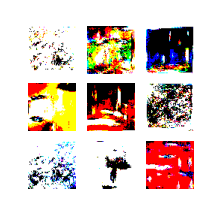

In [ ]:
num_of_epoch_to_display = 400
PIL.Image.open('./gen_images/image_epoch_{:03d}.png'.format(num_of_epoch_to_display))

### Restore the last Checkpoint (if needed)

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Generate and Plot different Images with different input noises

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


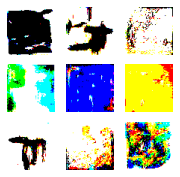

In [ ]:
new_input = tf.random.normal([num_examples_to_generate, noise_dim])
predictions = generator(new_input, training=False)
fig = plt.figure(figsize=(3, 3))
for i in range(num_examples_to_generate):
    plt.subplot(3, 3, i+1)
    plt.imshow(predictions[i, :, :, :] * 255)
    plt.axis('off')
    plt.savefig('./image_at_epoch_{:03d}.png'.format(4))
plt.show()